In [1]:
# Import the following libraries
import os
import random
import shutil

import numpy as np
from PIL import Image, ImageFilter
from matplotlib import pyplot as plt

In [2]:
train_dir = 'Train'
test_dir = 'Test'
#valid_dir = 'Validation'

In [3]:
# Import the Path class
from pathlib import Path  

train_dir = Path(train_dir)
test_dir = Path(test_dir)
#valid_dir = Path(valid_dir)

In [4]:
# Define the hyperparamenter

train_size = 3299
test_size = 379
img_height = 224
img_width = 224
n_classes = 8
batch_size = 32
n_epochs = 50

In [5]:
# The generator 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Standardize the data
datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create batches of data from each set train, test and validation)
train_ds = datagen.flow_from_directory(directory=train_dir,
                                               target_size=(img_height,
                                                            img_width),
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               batch_size=batch_size)

test_ds = datagen.flow_from_directory(directory=test_dir,
                                      target_size=(img_height, img_width),
                                      color_mode='rgb',
                                      class_mode='categorical',
                                      batch_size=batch_size)

Found 3299 images belonging to 8 classes.
Found 379 images belonging to 8 classes.


In [6]:
# What Labels correspond to what categories
labels = {value: key for key, value in train_ds.class_indices.items()}

print("Label encoding for classes present in the train dataset\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label encoding for classes present in the train dataset

0 : Anthracnose
1 : Bacterial Canker
2 : Cutting Weevil
3 : Die Back
4 : Gall Midge
5 : Healthy
6 : Powdery Mildew
7 : Scooty Mould


### How to deal with the train dataset which is clearly imbalanced

In [7]:
# Define the class weight function balance the train dataset
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight = "balanced", 
                                     classes= np.unique(train_ds.labels), 
                                     y= train_ds.labels)

In [8]:
class_weights = dict(zip(np.unique(train_ds.labels), class_weights))
class_weights

{0: 0.9634929906542056,
 1: 0.9501728110599078,
 2: 1.8744318181818183,
 3: 0.943649885583524,
 4: 0.9545717592592593,
 5: 0.9163888888888889,
 6: 0.9204799107142857,
 7: 0.9163888888888889}

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    break

(32, 224, 224, 3)


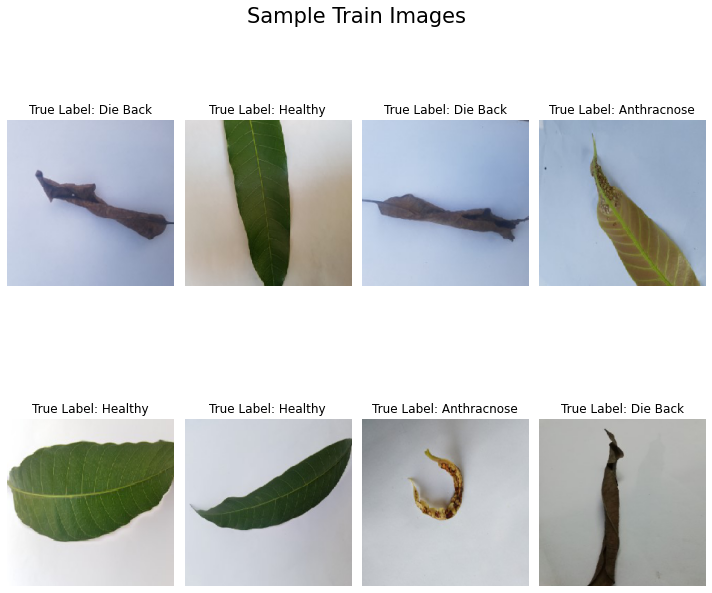

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10, 10))
idx = 0

for i in range(2):
    for j in range(4):
        label = labels[np.argmax(train_ds[0][1][idx])]
        ax[i, j].set_title(f"True Label: {label}")
        ax[i, j].imshow(train_ds[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Train Images", fontsize=21)
plt.show()    

In [11]:
print('Number of samples: ',train_ds.samples)
print('Number of classes: ',len(train_ds.class_indices))
print('Number of samples per class:', int(train_ds.samples/len(train_ds.class_indices)))

Number of samples:  3299
Number of classes:  8
Number of samples per class: 412


In [12]:
# Import all the tensorflow libraries as required for the model

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

### We create a Light weight CNN model from scratch

In [13]:
# Define a simple lightweight CNN model
def light_cnn():
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    return model

In [14]:
# Create the light CNN model
model_light = light_cnn()

2023-09-12 14:39:53.117517: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model_light.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 93312)             0         
                                                                 
 dense (Dense)               (None, 256)               2

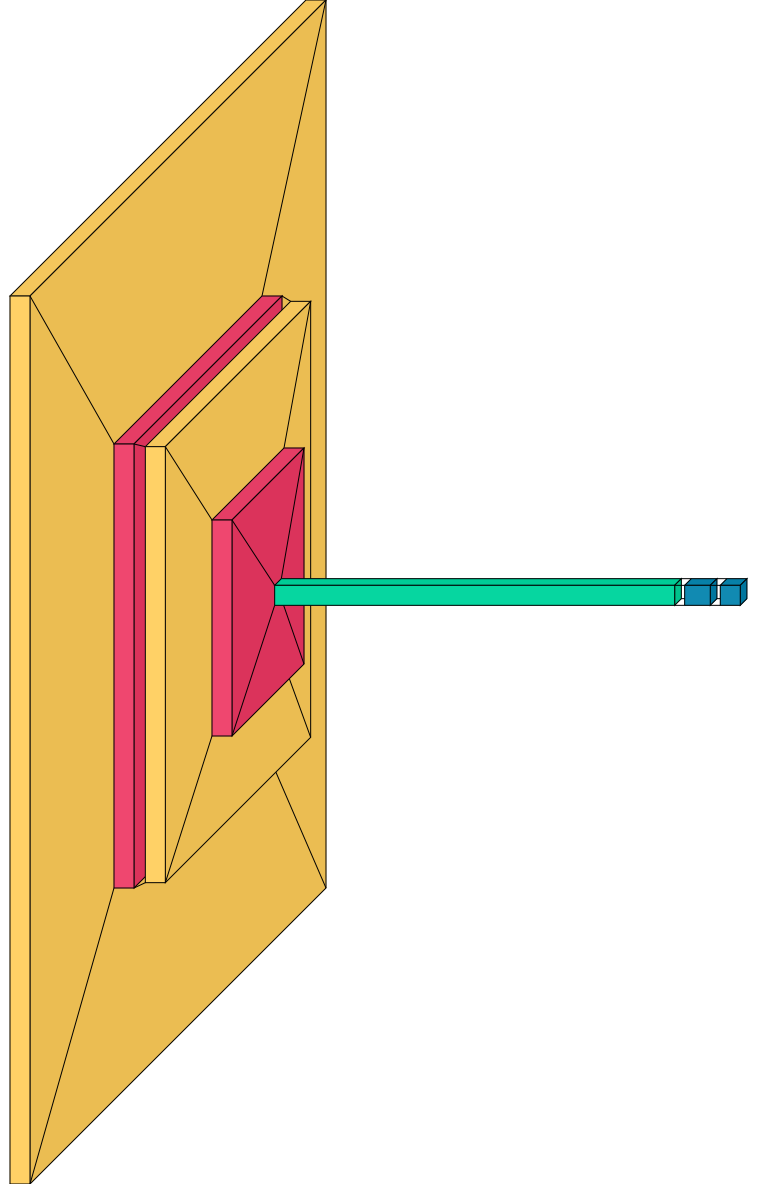

In [16]:
# Let us visualise the model
import visualkeras
visualkeras.layered_view(model_light)

In [17]:
# Utilize the Adam Optimizers
opt = keras.optimizers.Adam(learning_rate=1e-5)
model_light.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])  

# Use Early Stopping
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)

In [18]:
history = model_light.fit(
    train_ds, class_weight=class_weights,
    epochs=n_epochs,
    validation_data=test_ds,  # Use the test dataset for validation
    steps_per_epoch=train_size // batch_size,  # Use integer division
    validation_steps=test_size // batch_size,  # Use integer division
    callbacks=[es])

Epoch 1/50
103/103 [==============================] - 231s 2s/step - loss: 1.8182 - accuracy: 0.3015 - val_loss: 1.6617 - val_accuracy: 0.4574
Epoch 2/50
103/103 [==============================] - 217s 2s/step - loss: 1.4225 - accuracy: 0.5017 - val_loss: 1.4043 - val_accuracy: 0.5426
Epoch 3/50
103/103 [==============================] - 222s 2s/step - loss: 1.2313 - accuracy: 0.5650 - val_loss: 1.2602 - val_accuracy: 0.5653
Epoch 4/50
103/103 [==============================] - 224s 2s/step - loss: 1.0870 - accuracy: 0.6358 - val_loss: 1.1388 - val_accuracy: 0.6250
Epoch 5/50
103/103 [==============================] - 224s 2s/step - loss: 0.9705 - accuracy: 0.6829 - val_loss: 1.0995 - val_accuracy: 0.5597
Epoch 6/50
103/103 [==============================] - 221s 2s/step - loss: 0.8810 - accuracy: 0.7221 - val_loss: 0.9594 - val_accuracy: 0.7102
Epoch 7/50
103/103 [==============================] - 222s 2s/step - loss: 0.7983 - accuracy: 0.7502 - val_loss: 0.8810 - val_accuracy: 0.7415

### Plot the learning curves

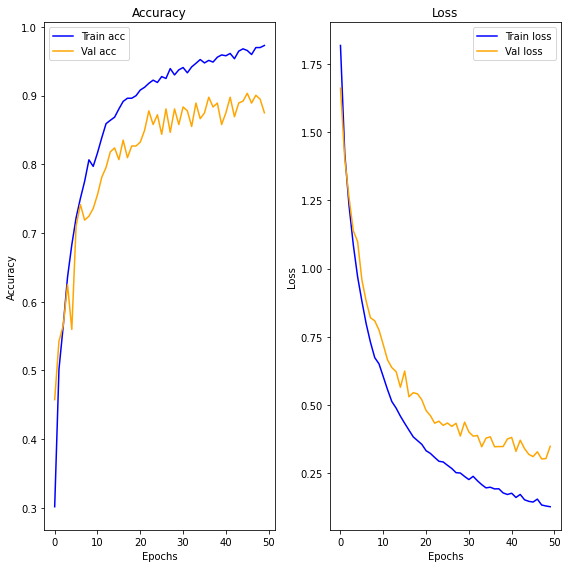

In [19]:
# Create a figure with two subplots, one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(8, 8))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Train acc', color='blue')
axes[0].plot(history.history['val_accuracy'], label='Val acc', color='orange')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy')
axes[0].legend()

# Plot loss
axes[1].plot(history.history['loss'], label='Train loss', color='blue')
axes[1].plot(history.history['val_loss'], label='Val loss', color='orange')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss')
axes[1].legend()

plt.tight_layout()  # Ensure that subplots don't overlap
plt.show()

In [20]:
test_loss, test_accuracy = model_light.evaluate(test_ds)

12/12 [==============================] - 6s 515ms/step - loss: 0.3351 - accuracy: 0.8813


In [21]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.3351433277130127
Test Accuracy: 0.8812664747238159


### Plot the confusion matrix

In [22]:
preds = model_light.predict(test_ds, batch_size=batch_size)

y_true = test_ds.classes
y_pred=np.argmax(preds,axis=1)

In [23]:
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(test_ds.classes, y_pred)

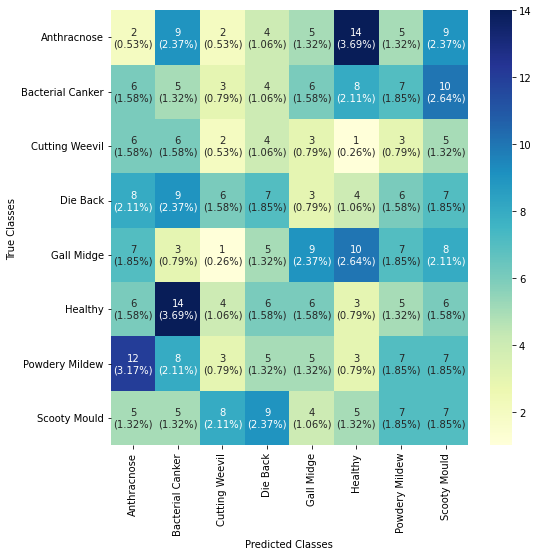

In [24]:
import seaborn as sns 

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(8, 8)

plt.figure(figsize = (8, 8))
sns.heatmap(cm, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

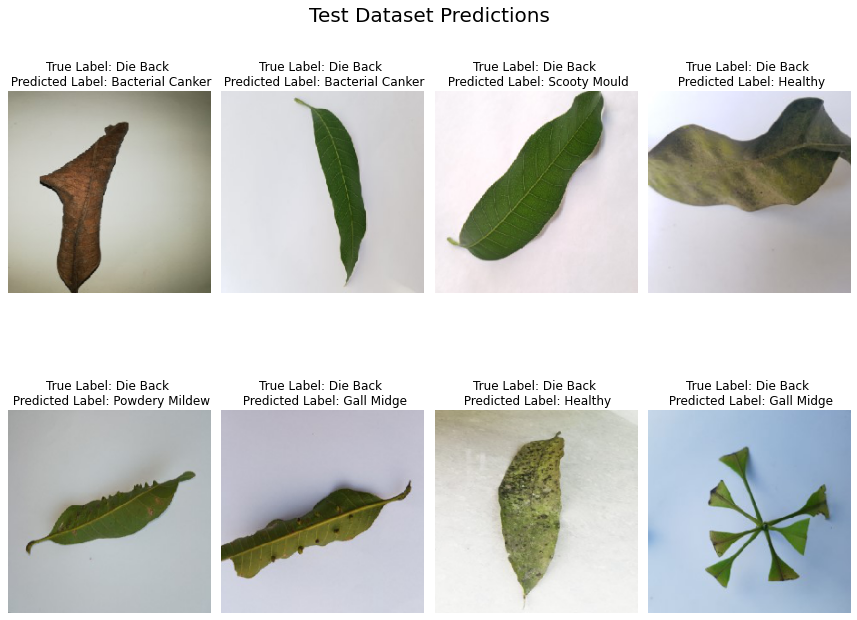

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(4):
        predicted_label = labels[np.argmax(preds[idx])]
        ax[i, j].set_title(f"True Label: {label} \n Predicted Label: {predicted_label}")
        ax[i, j].imshow(test_ds[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=labels.values()))

                  precision    recall  f1-score   support

     Anthracnose       0.04      0.04      0.04        50
Bacterial Canker       0.08      0.10      0.09        49
  Cutting Weevil       0.07      0.07      0.07        30
        Die Back       0.16      0.14      0.15        50
      Gall Midge       0.22      0.18      0.20        50
         Healthy       0.06      0.06      0.06        50
  Powdery Mildew       0.15      0.14      0.14        50
    Scooty Mould       0.12      0.14      0.13        50

        accuracy                           0.11       379
       macro avg       0.11      0.11      0.11       379
    weighted avg       0.11      0.11      0.11       379



In [27]:
# Save the model

model_light.save('CNNLIGHT.h5')